In [1]:
#!unzip dank_data-master.zip
#!pip install tensorflow_addons

In [2]:
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Embedding,LSTM,concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training='/content/dank_data-master/data/training/*'
test='/content/dank_data-master/data/test/*'
validation='/content/dank_data-master/data/validation/*'

In [4]:
training = glob.glob(training)
test = glob.glob(test)
validation = glob.glob(validation)

In [5]:
final_dank=pd.read_csv('/content/dank_data-master/data/final_dank.csv')
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in training]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation]
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test]

In [6]:
for labels in train_labels:
    if labels==train_labels[0]:
        train_data =final_dank[final_dank['id']==labels]
    else :
        train_data =train_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in validation_labels:
    if labels==validation_labels[0]:
        val_data =final_dank[final_dank['id']==labels]
    else :
        val_data =val_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in test_labels:
    if labels==test_labels[0]:
        test_data =final_dank[final_dank['id']==labels]
    else :
        test_data =test_data.append(final_dank[final_dank['id']==labels],sort=False)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
train_data.head(5)

(3405, 68)
(1719, 68)
(1688, 68)


,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
57342,102450,7205.0,38858.0,DogOfLight,[],"['favorit', 'schoolpe', 'street', 'hawa', 'sch...",1.584874e+09,0.0,fmy0i8,False,https://i.redd.it/uv7hvczyd7o41.png,r/memes,10674298.0,117.0,https://b.thumbs.redditmedia.com/oNk6cGjONwtqV...,140.0,My favorite school,34.0,/r/memes/comments/fmy0i8/my_favorite_school/,2020-03-22 05:43:19,1.0,3.185221e-06,0.0,85.0,0.49,5.0,212.076355,219.032808,10.737153,225.579740,19.006448,225.629684,5.556805,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.067394,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.074780,0.162480,0.099965,0.058334,wool,triceratops,kite
46401,77706,81429.0,13082.0,Chronus112110,[],"['long', 'come', 'extrem', 'toilet', 'paper', ...",1.584522e+09,0.0,fkmhkb,False,https://i.redd.it/au8u095naen41.jpg,r/memes,10674201.0,78.0,https://b.thumbs.redditmedia.com/Ih_-MDqh2d_e6...,140.0,Not long now... its all almost over when it co...,22.0,/r/memes/comments/fkmhkb/not_long_now_its_all_...,2020-03-18 03:52:54,0.0,2.061044e-06,0.0,186.0,0.31,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,1907,1996.0,1996.0,usamarafiq,[],"['me_irlthi', 'ship', 'ship', 'ship', 'ship', ...",1.584439e+09,0.0,fk2q9h,False,https://i.redd.it/oztkr0wki7n41.jpg,r/me_irl,3672379.0,139.0,https://b.thumbs.redditmedia.com/ldceth0Rvlx2r...,140.0,Me_irl,898.0,/r/me_irl/comments/fk2q9h/me_irl/,2020-03-17 05:04:59,1.0,2.445281e-04,1.0,61.0,0.50,7.0,234.042665,234.612695,8.163310,234.828678,2.424815,235.290443,2.473646,0.0,0.000000,8.576702,0.0,0.000000,0.031378,0.000000,0.000000,0.821062,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.436013,0.000000,0.0,0.0,0.0,0.0,0.064500,0.0,0.000000,0.0,0.0,0.821062,0.339930,0.256677,0.159502,0.033848,menu,web_site,crossword_puzzle
67637,132246,8203.0,69856.0,usamarafiq,[],"['me_irlthi', 'ship', 'ship', 'ship', 'ship', ...",1.584439e+09,0.0,fk2q9h,False,https://i.redd.it/oztkr0wki7n41.jpg,r/me_irl,3952036.0,139.0,https://b.thumbs.redditmedia.com/ldceth0Rvlx2r...,140.0,Me_irl,894.0,/r/me_irl/comments/fk2q9h/me_irl/,2020-03-17 05:04:59,1.0,2.262125e-04,1.0,61.0,0.50,7.0,151.357919,181.271252,25.566028,188.723981,58.246440,192.169324,19.004122,0.0,0.020449,0.925310,0.0,1.299523,5.208317,0.001022,1.384386,0.003067,0.0,0.0,0.0,0.0,0.0,0.025561,0.007157,0.912018,0.395685,0.0,0.0,0.0,0.0,0.418179,0.0,0.012269,0.0,0.0,0.003067,37.604379,0.336461,0.074707,0.057633,comic_book,envelope,packet
60768,107533,12496.0,44149.0,giantlaserbeams,[],"['home', 'ventil', 'see', 'problem', 'laura', ...",1.584830e+09,0.0,fmol1o,False,https://i.redd.it/h9zklisxs3o41.jpg,r/memes,10674319.0,140.0,default,140.0,At home ventilators,2.0,/r/memes/comments/fmol1o/at_home_ventilators/,2020-03-21 17:40:43,4.0,1.873656e-07,0.0,185.0,0.21,18.0,116.148660,121.140933,15.525022,131.020537,55.361438,131.069590,0.943315,0.0,0.000000,33.661584,0.0,1.799218,0.010471,0.010471,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.304565,0.000455,0.0,0.0,0.0,0.0,9.995403,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.617798,0.031589,0.018686,web_site,notebook,hand-held_computer


In [7]:
def file_extension(x):
      return x+".jpg"
train_data['id'] = train_data['id'].apply(file_extension)
val_data['id'] = val_data['id'].apply(file_extension)
test_data['id'] = test_data['id'].apply(file_extension)

In [8]:
def numeric_to_string(x):
    if (x==1.0):
        return 'Not_dank'
    elif (x==0.0):
        return 'Dank'
train_data['dank_level_new'] = train_data['dank_level'].apply(numeric_to_string)
val_data['dank_level_new'] = val_data['dank_level'].apply(numeric_to_string)
test_data['dank_level_new'] = test_data['dank_level'].apply(numeric_to_string)

In [9]:
  train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                    horizontal_flip=True, fill_mode='nearest')
  train_generator = train_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              has_ext=False,
              subset="training",
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (512,512))
  predict_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  train_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              has_ext=False,
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (512,512))
  validation_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=val_data,
              directory="/content/dank_data-master/data/validation/",
              x_col="id",
              y_col="dank_level_new",
              has_ext=False,
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (512,512))
  test_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=test_data,
              directory="/content/dank_data-master/data/test/",
              x_col="id",
              y_col="dank_level_new",
              has_ext=False,
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (512,512))

Found 3405 validated image filenames belonging to 2 classes.
Found 3405 validated image filenames belonging to 2 classes.
Found 1688 validated image filenames belonging to 2 classes.
Found 1719 validated image filenames belonging to 2 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [10]:
IMAGE_SIZE = [512,512]
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
for layer in vgg16.layers[:11]:
    layer.trainable = False

In [12]:
#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(vgg16.output)

#FC layer
FC1 = Dense(units=256,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)
x = Dropout(0.3)(FC1)
#FC layer
FC2 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(x)
x = Dropout(0.3)(FC2)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(x)

model = Model(inputs=vgg16.input, outputs=Out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [13]:
def scheduler(epoch,lr):
    if((epoch+1)%3==0):
        lr=lr*0.95
        return lr
    else:
        return lr

In [16]:

filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=3,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=3, min_lr=0.001,verbose=1)

model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=1)]
)


In [17]:
history=model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=50,validation_data=test_prediction_generator,validation_steps=len(test_prediction_generator),use_multiprocessing=False,workers=12,callbacks=[lrschedule,checkpoint,reduce_lr])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 286s 2s/step - loss: 0.6622 - accuracy: 0.5784 - precision_1: 0.5835 - recall_1: 0.5762 - f1_score: 0.6710 - val_loss: 0.6869 - val_accuracy: 0.5625 - val_precision_1: 0.6321 - val_recall_1: 0.2274 - val_f1_score: 0.6518
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 285s 2s/step - loss: 0.6617 - accuracy: 0.5967 - precision_1: 0.6028 - recall_1: 0.5353 - f1_score: 0.6599 - val_loss: 0.7020 - val_accuracy: 0.5608 - val_precision_1: 0.6218 - val_recall_1: 0.2335 - val_f1_score: 0.6518
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.499999760009813e-06.
114/114 [==============================] - 285s 2s/step - loss: 0.6503 - accuracy: 0.6058 - precision_1: 0.6117 - recall_1: 0.5783 - f1_score: 0.6658 - val_loss: 0.6869 - val_accuracy:

In [18]:
model_checkpoint =  Model(inputs=vgg16.input, outputs=Out)
model_checkpoint.load_weights('/content/model_save/weights-05-0.6009.h5')
model_checkpoint.save('bestmodel.h5')
new_model = tf.keras.models.load_model('bestmodel.h5')

In [19]:
test_prediction=new_model.predict_generator(test_prediction_generator,steps=len(test_prediction_generator),workers=12)
test_prediction=((test_prediction > 0.5)+0).ravel() 
print(test_prediction.shape)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test=np.argmax(y_test,axis=-1)
y_test.shape

(1719,)


(1719,)

Test accuracy_score 0.6009307737056429
Test F1_score 0.5674653215636822
Test confusion matrix


Text(0.5, 15.0, 'Predicted label')

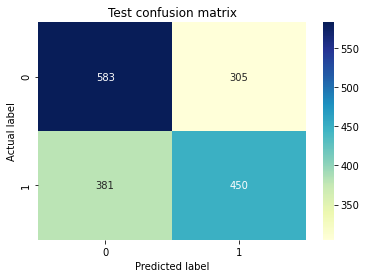

In [20]:
accuracy=accuracy_score(y_test,test_prediction)
print("Test accuracy_score",accuracy)
f1_test_score=f1_score(y_test,test_prediction)
print("Test F1_score",f1_test_score)
print("Test confusion matrix")
cnf_matrix2=confusion_matrix(y_test,test_prediction)
p = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Test confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

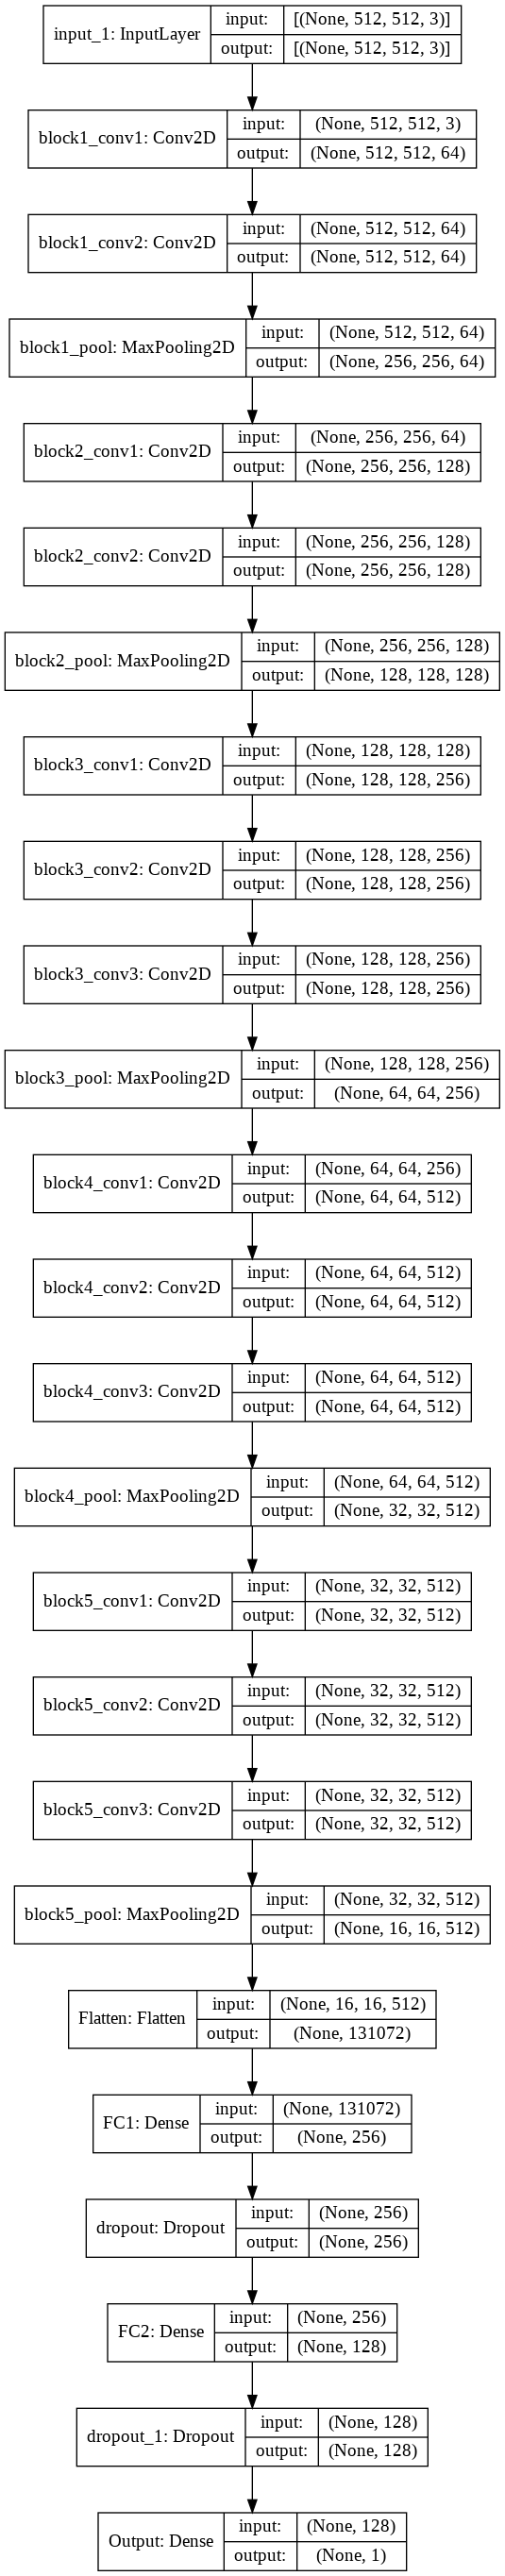

In [21]:
file = '/content/model_1.png'
tf.keras.utils.plot_model(model,to_file=file, show_shapes=True)

Performance

simple convultion model - Accuracy : 0.5101 , F1_score :0.4028

lstm model - Accuracy : 0.5439 , F1_score :0.5037

simple conv with lstm model- Accuracy : 0.5107, F1_score : 0.0927

VGG16 with lstm : Accuracy :0.5340 , F1_score 0.3206

VGG19 with lstm: Accuracy :0.5340 , F1_score :0.1633

Resnet with lstm: Accuracy :0.5218 , F1_score: 0.0743

VGG16 with imagesize(299,299) : Accuracy: 0.4892, F1_score: 0.5378

VGG19 : Accuracy: 0.4863, F1_score: 0.4997

VGG16 with imagesize(156,156) : Accuracy: 0.5596 , F1_score: 0.5112

VGG16 with imagesize(256,256) : Accuracy: 0.5049, F1_score: 0.5020

VGG16 with imagesize(512,512) : Accuracy: 0.6009, F1_score: 0.5674

<h2>Conclusion</h2>
model with VGG16 image size (156,156) or (512,512) performs well than others models